# QSAR_Aquatic_Toxicity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import scipy
import seaborn as sns
import math
import pickle

from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (confusion_matrix,plot_confusion_matrix,
                            ConfusionMatrixDisplay,accuracy_score,f1_score,
                            mean_squared_error, mean_absolute_error, max_error,
                            r2_score, explained_variance_score)

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

## Loading Data

In [2]:
Datset = pd.read_csv('Regression_Datasets/3_Qsar_Aquatic_Toxicity/Qsar_Aquatic_Toxicity.csv', delimiter=';') 


In [3]:
df = pd.DataFrame(Datset)
df.head()

,0,0.1,0.2,2.419,1.225,0.667,0.3,0.4,3.740
0,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
1,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
2,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
3,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
4,215.34,327.629,3,0.189,4.677,1.333,0,4,6.064


## Data Prepration And Analysis

In [10]:
print(np.count_nonzero(Datset==np.nan))

0


In [11]:
# MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r', 'knn_r', 'adaboost_r', 'gaussian_process_r', 'neural_network_r'}
MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r'}
qsar_aquatic_toxicity_dict = {}  

## Train and Test set

In [12]:
x = df.iloc[:,:-1]
y = df.iloc[:, -1:]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state=0)

y_train = y_train.to_numpy().reshape(-1)
y_test = y_test.to_numpy().reshape(-1)

In [14]:
StScale = StandardScaler()
X_train = StScale.fit_transform(X_train)
X_test = StScale.transform(X_test)

In [15]:
from tabulate import tabulate
def model_results(model):
    table = [["Parameters / Metrics", "Tuned"]]
    curr_model = model['model']
    
    if model['hyperparameters'] == 1:
        for param in curr_model.best_params_:
            table.append([param, curr_model.best_params_[param]])
    
    linear_r_predict = curr_model.predict(X_test)
    mse = mean_squared_error(y_test, linear_r_predict)
    model['mse'] = mse
    r2 = r2_score(y_test, linear_r_predict)
    model['r2'] = r2
    table.append(['Mean Squarred Error', mse])
    table.append(['r2 Score',r2])
    
    print(tabulate(table, headers='firstrow', tablefmt='grid'))

## Linear Regression

In [16]:
linear_r = LinearRegression()
linear_r.fit(X_train, y_train)

qsar_aquatic_toxicity_dict['linear_r'] = {'model':linear_r, 'hyperparameters':0}

## Linear Regression Analysis

In [17]:
model_results(qsar_aquatic_toxicity_dict['linear_r'])

+------------------------+----------+
| Parameters / Metrics   |    Tuned |
+========================+==========+
| Mean Squarred Error    | 1.03838  |
+------------------------+----------+
| r2 Score               | 0.574774 |
+------------------------+----------+


## Support Vector Regression

In [18]:
svr = SVR().fit(X_train,y_train)

In [31]:
parameters = {
    'C': scipy.stats.uniform(1, 1000), 
    'gamma': scipy.stats.uniform(0.01, 1000)
}
svr_model = RandomizedSearchCV(svr, parameters, verbose=1, n_iter=100, random_state=0).fit(X_train, y_train)
svr_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'C': 829.9400292173631, 'gamma': 4.705476192547065}

In [29]:
svr_model.best_estimator_

SVR(C=2657.8800584347264, gamma=4.705476192547065)

## Support Vector Regression Analysis

In [32]:
qsar_aquatic_toxicity_dict['svr'] = {'model':svr_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['svr'])

+------------------------+------------+
| Parameters / Metrics   |      Tuned |
+========================+============+
| C                      | 829.94     |
+------------------------+------------+
| gamma                  |   4.70548  |
+------------------------+------------+
| Mean Squarred Error    |   1.93509  |
+------------------------+------------+
| r2 Score               |   0.207559 |
+------------------------+------------+


## Decision Tree Regression

In [33]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
parameters = {
    'max_depth': scipy.stats.uniform(1, 100),
    'min_samples_split': scipy.stats.uniform(0, 1) 
}
tree_model = RandomizedSearchCV(tree, parameters, verbose=1, n_iter=50, random_state=0).fit(X_train, y_train)
tree_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'max_depth': 84.7944907498804, 'min_samples_split': 0.09609840789396307}

## Decision tree Analysis

In [47]:
qsar_aquatic_toxicity_dict['decision_tree_r'] = {'model':tree_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['decision_tree_r'])

+------------------------+------------+
| Parameters / Metrics   |      Tuned |
+========================+============+
| max_depth              | 84.7945    |
+------------------------+------------+
| min_samples_split      |  0.0960984 |
+------------------------+------------+
| Mean Squarred Error    |  1.70203   |
+------------------------+------------+
| r2 Score               |  0.303     |
+------------------------+------------+


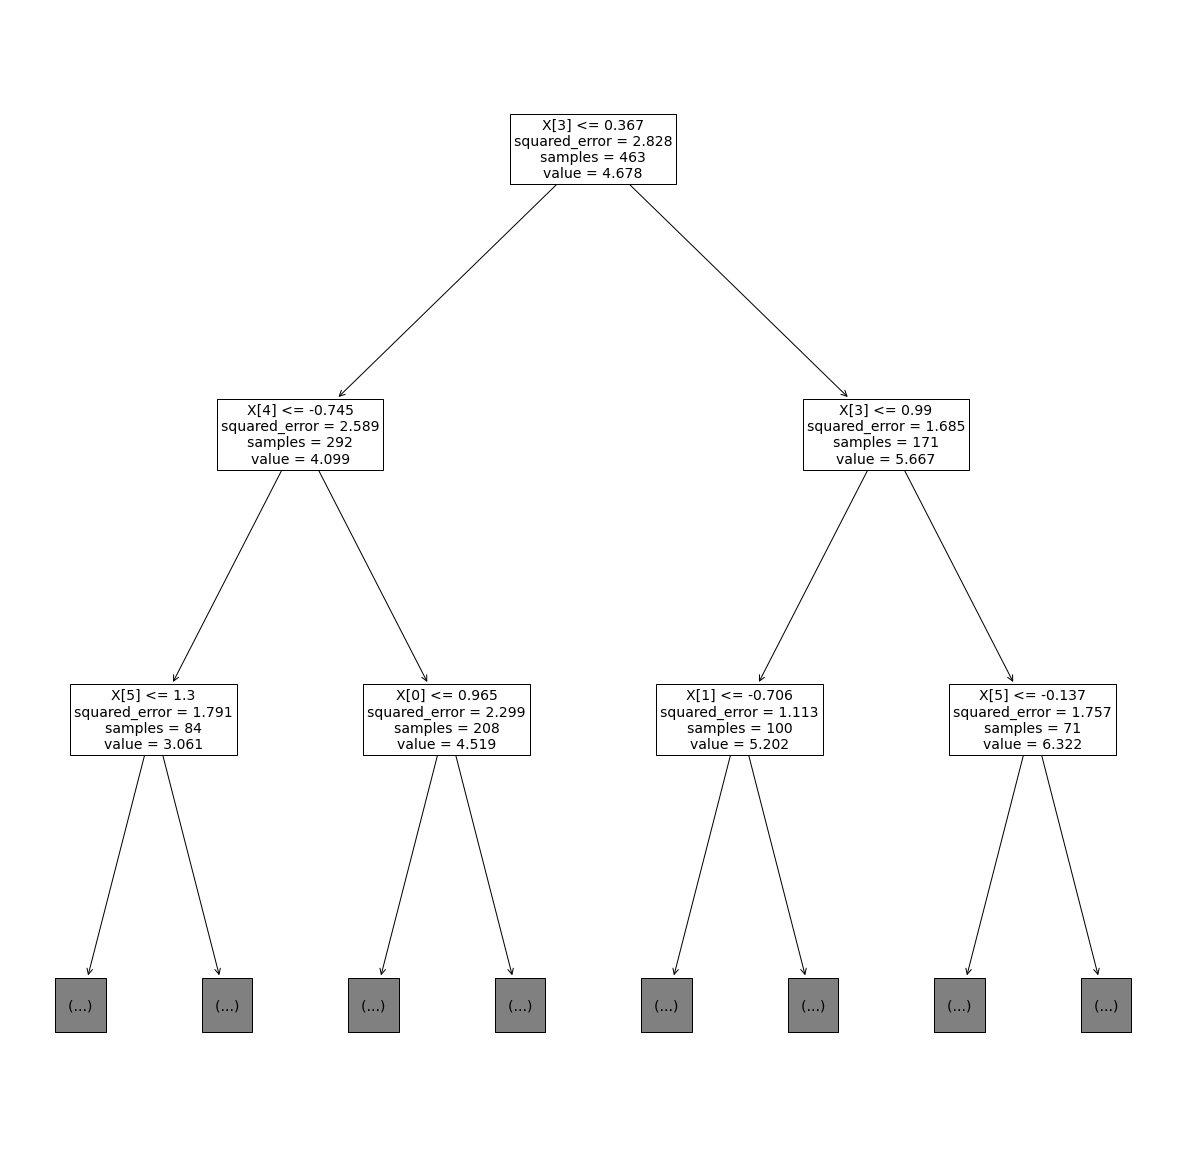

In [48]:
plt.figure(figsize=(21,21))
plot_tree(tree, max_depth = 2, fontsize=14);

## Random Forest Regression

In [49]:
forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

In [50]:
parameters = {
    'n_estimators': range(100,150),
    'max_depth': scipy.stats.uniform(1, 100),
}
forest_model = RandomizedSearchCV(forest, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
forest_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 27.455561210462697, 'n_estimators': 111}

## Random Forest Analysis

In [51]:
qsar_aquatic_toxicity_dict['random_forest_r'] = {'model':forest_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['random_forest_r'])

+------------------------+------------+
| Parameters / Metrics   |      Tuned |
+========================+============+
| max_depth              |  27.4556   |
+------------------------+------------+
| n_estimators           | 111        |
+------------------------+------------+
| Mean Squarred Error    |   0.915077 |
+------------------------+------------+
| r2 Score               |   0.625266 |
+------------------------+------------+


## K Nearest Neighbours Regression

In [50]:
# knn = KNeighborsClassifier()

In [85]:
# parameters = {
#     'n_neighbors': range(1, 100), 
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
#     'weights': ['uniform', 'distance'], 
#     'leaf_size': scipy.stats.uniform(1, 50)
# }
# knn_model = RandomizedSearchCV(knn, parameters,verbose=10,random_state=0).fit(X_train, y_train)
# knn_model.best_params_

In [56]:
# knn_model.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=41.60843643877466,
                     n_neighbors=47)

## KNN Analysis

In [57]:
knn_predictions = knn_model.predict(X_test)

+-----------------+-----------------------+------------+
| Model Name      |   Mean Squarred Error |   r2 Score |
+=================+=======================+============+
| svr             |              1.93509  |   0.207559 |
+-----------------+-----------------------+------------+
| linear_r        |              1.03838  |   0.574774 |
+-----------------+-----------------------+------------+
| decision_tree_r |              1.70203  |   0.303    |
+-----------------+-----------------------+------------+
| random_forest_r |              0.915077 |   0.625266 |
+-----------------+-----------------------+------------+


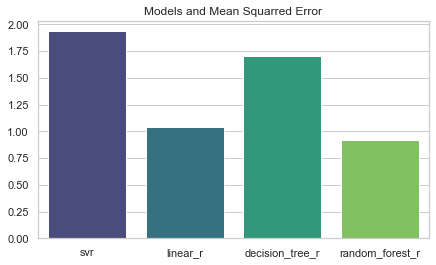

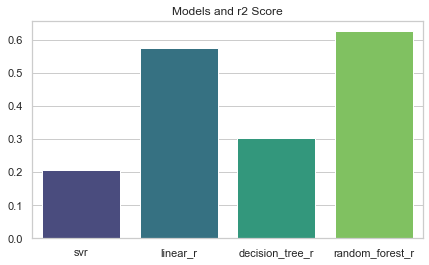

In [52]:
def cross_checking_model_results(dictionary):
    table = [["Model Name", "Mean Squarred Error", "r2 Score"]]
    x_models = []
    y_mse = []
    y_r2 = []
    
    for model_key in MODELS:
        table.append([model_key, dictionary[model_key]['mse'], dictionary[model_key]['r2']])
        x_models.append(model_key)
        y_mse.append(dictionary[model_key]['mse'])
        y_r2.append(dictionary[model_key]['r2'])
    print(tabulate(table, headers='firstrow', tablefmt='grid'))
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(7,4))
    ax1 = sns.barplot(x=x_models, y=y_mse, palette="viridis").set_title('Models and Mean Squarred Error')
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=y_r2, palette="viridis").set_title('Models and r2 Score')


cross_checking_model_results(qsar_aquatic_toxicity_dict)

### Regression Dictionary
Exporting Model Data for Later Analysis and Comparison

In [4]:
with open('base_regression_dict.dictionary', 'rb') as config_dictionary_file:
    base_regression_dict = pickle.load(config_dictionary_file)

base_regression_dict['qsar_aquatic_toxicity']= qsar_aquatic_toxicity_dict

with open('base_regression_dict.dictionary', 'wb') as config_dictionary_file:
    pickle.dump(base_regression_dict, config_dictionary_file)

NameError: name 'qsar_aquatic_toxicity_dict' is not defined